In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
elif torch.backends.mps.is_available():  # Check if MPS (Apple GPU) is available
    device = torch.device("mps")
    print("Using Apple GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: CUDA


In [4]:
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Remove the first max pooling layer
model.maxpool = nn.Identity()

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [6]:
def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}"
        )


def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, testloader)

# Save the model
torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

Epoch [1/20], Loss: 0.6541
Epoch [2/20], Loss: 0.2375
Epoch [3/20], Loss: 0.1048
Epoch [4/20], Loss: 0.0546
Epoch [5/20], Loss: 0.0358
Epoch [6/20], Loss: 0.0284
Epoch [7/20], Loss: 0.0224
Epoch [8/20], Loss: 0.0158
Epoch [9/20], Loss: 0.0156
Epoch [10/20], Loss: 0.0205
Epoch [11/20], Loss: 0.0194
Epoch [12/20], Loss: 0.0120
Epoch [13/20], Loss: 0.0138
Epoch [14/20], Loss: 0.0151
Epoch [15/20], Loss: 0.0093
Epoch [16/20], Loss: 0.0072
Epoch [17/20], Loss: 0.0053
Epoch [18/20], Loss: 0.0025
Epoch [19/20], Loss: 0.0009
Epoch [20/20], Loss: 0.0005
Accuracy: 93.24%


In [7]:
# Create patch (random initialization)
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)  # RGB
    return patch

In [8]:
def place_patch(img, patch):
    patch = patch.to(img.device)
    patched_img = img.clone()
    batch_size, _, h, w = patched_img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        patched_img[i, :, x_offset : x_offset + ph, y_offset : y_offset + pw] = patch
    return patched_img

In [9]:
def patch_training_step(
    model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None
):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        patched_images = place_patch(images, patch)  # Apply patch to images
        outputs = model(patched_images)

        if target_class is not None:
            labels = torch.full(
                (images.size(0),), target_class, dtype=torch.long, device=device
            )
            loss = criterion(outputs, labels)
        else:
            loss = -criterion(outputs, labels)  # reverse the loss

        # loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            patch.clamp_(-1, 1)  # Ensure the patch values remain within a valid range

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [10]:
def train_adversarial_patch(
    model, patch, dataloader=None, target_class=None, num_epochs=20, lr=0.0001
):
    if dataloader is None:
        dataloader = trainloader

    patch_optimizer = optim.Adam(
        [patch], lr=lr
    )  # Use Adam optimizer for learning rate adjustment

    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(
            model, patch, target_class, dataloader, patch_optimizer, criterion
        )
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

In [11]:
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (
                    (predicted != labels).sum().item()
                )  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total

    if target_class is not None:
        print(f"Targeted Attack Success Rate (Class {target_class}): {accuracy:.2f}%")
    else:
        print(f"Untargeted Attack Success Rate: {accuracy:.2f}%")

In [12]:
target_classes = [0, 1, 2]
class_names = {0: "airplane", 1: "automobile", 2: "bird"}

### 3 by 3

In [13]:
import torchvision.models as models

model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-267676bc78cc>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

<All keys matched successfully>

In [14]:
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )

    patch_size = (3, 3)
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: airplane (0) ---
Epoch 1/20, Loss: 14.1647
Epoch 2/20, Loss: 14.1435
Epoch 3/20, Loss: 14.1209
Epoch 4/20, Loss: 14.1133
Epoch 5/20, Loss: 14.0903
Epoch 6/20, Loss: 14.0764
Epoch 7/20, Loss: 14.0509
Epoch 8/20, Loss: 14.0523
Epoch 9/20, Loss: 14.0296
Epoch 10/20, Loss: 14.0188
Epoch 11/20, Loss: 14.0120
Epoch 12/20, Loss: 13.9918
Epoch 13/20, Loss: 13.9870
Epoch 14/20, Loss: 13.9716
Epoch 15/20, Loss: 13.9653
Epoch 16/20, Loss: 13.9709
Epoch 17/20, Loss: 13.9536
Epoch 18/20, Loss: 13.9383
Epoch 19/20, Loss: 13.9333
Epoch 20/20, Loss: 13.9250
Saved patch to adversarial_patch_airplane_(3, 3).pth
--- Evaluating Patch for Target Class: airplane (0) ---
Targeted Attack Success Rate (Class 0): 10.36%

--- Training Patch for Target Class: automobile (1) ---
Epoch 1/20, Loss: 14.0231
Epoch 2/20, Loss: 14.0145
Epoch 3/20, Loss: 14.0005
Epoch 4/20, Loss: 13.9975
Epoch 5/20, Loss: 13.9992
Epoch 6/20, Loss: 13.9944
Epoch 7/20, Loss: 13.9819
Epoch 8/20, Loss: 1

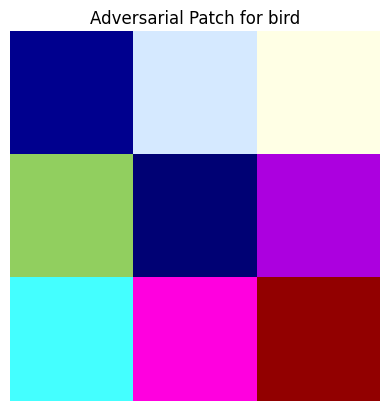

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_patch(patch, title="Adversarial Patch"):
    # Detach and move to CPU
    patch = patch.detach().cpu()
    # Convert to numpy and transpose to (H, W, C)
    patch_np = patch.permute(1, 2, 0).numpy()
    # Unnormalize if necessary
    patch_np = (patch_np * 0.5) + 0.5  # Assuming normalization was (-1, 1)
    patch_np = np.clip(patch_np, 0, 1)

    plt.imshow(patch_np)
    plt.title(title)
    plt.axis("off")
    plt.show()


visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

In [16]:
# Define the class names for CIFAR-10
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [17]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Denormalize a tensor image.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (tuple): Mean used for normalization.
        std (tuple): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [18]:
def visualize_misclassified_patched_images(
    model, patch, dataloader, target_class=None, num_images=5
):
    """
    Visualize misclassified images after applying the adversarial patch.

    Args:
        model (nn.Module): Trained CIFAR-10 classifier.
        patch (torch.Tensor): Trained adversarial patch.
        dataloader (DataLoader): DataLoader for evaluation data.
        target_class (int, optional): Target class for targeted attacks. Defaults to None for untargeted attacks.
        num_images (int, optional): Number of misclassified images to visualize. Defaults to 5.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            if target_class is not None:
                # Only include images not originally of target_class but predicted as target_class
                mask = (predicted == target_class) & (labels != target_class)
            else:
                # Untargeted Attack: Any prediction that doesn't match the true label
                mask = predicted != labels

            for i in range(images.size(0)):
                if mask[i]:
                    misclassified.append(
                        (
                            images[i].cpu(),
                            patched_images[i].cpu(),
                            labels[i].cpu(),
                            predicted[i].cpu(),
                        )
                    )
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("No misclassified images found with the current patch.")
        return

    # Plotting
    for idx, (orig, patched, true_label, pred_label) in enumerate(misclassified):
        orig = denormalize(orig).permute(1, 2, 0).numpy()
        patched = denormalize(patched).permute(1, 2, 0).numpy()

        orig = np.clip(orig, 0, 1)
        patched = np.clip(patched, 0, 1)

        plt.figure(figsize=(4, 2))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title(f"Original\nTrue: {class_names[true_label.item()]}")
        plt.axis("off")

        # Patched Image
        plt.subplot(1, 2, 2)
        plt.imshow(patched)
        plt.title(f"Patched\nPredicted: {class_names[pred_label.item()]}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

<ipython-input-19-f5285ffa1fb1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 0): 10.44%


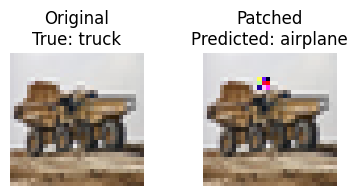

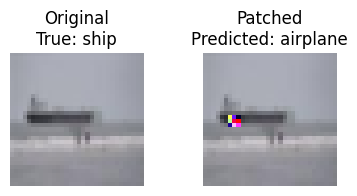

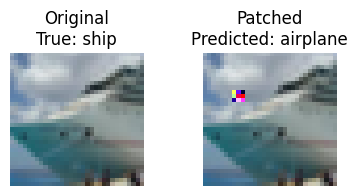

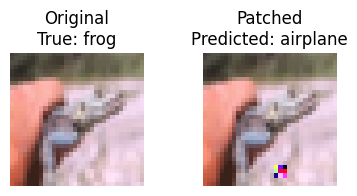

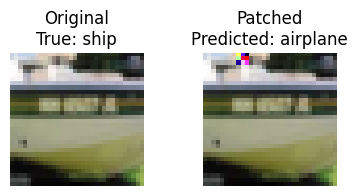

Targeted Attack Success Rate (Class 1): 9.82%


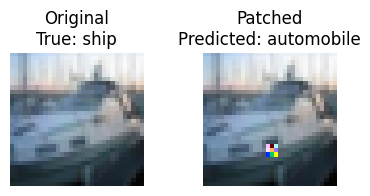

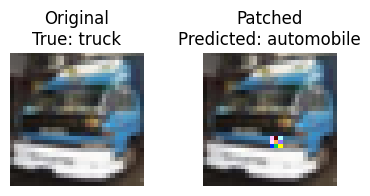

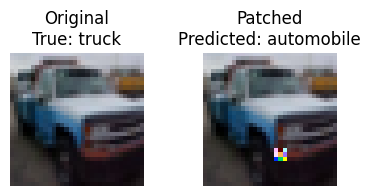

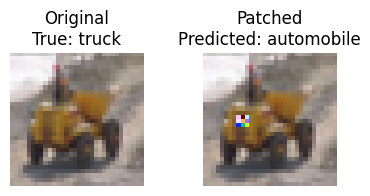

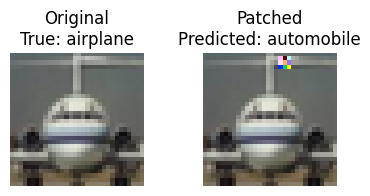

Targeted Attack Success Rate (Class 2): 10.01%


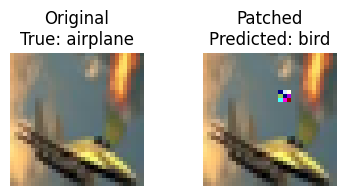

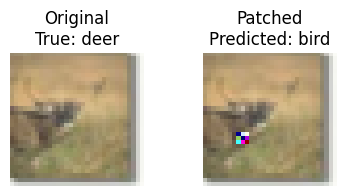

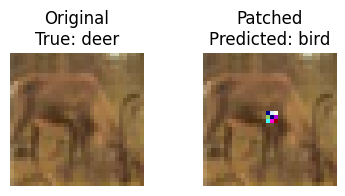

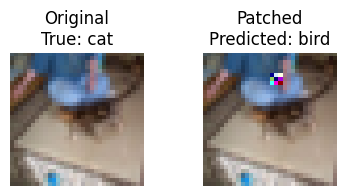

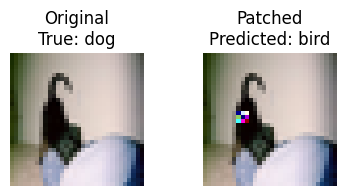

In [19]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 16 by 16

In [20]:
model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

<ipython-input-20-f07af1de2043>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)


<All keys matched successfully>

In [21]:
patch_size = (16, 16)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: airplane (0) ---
Epoch 1/20, Loss: 9.3000
Epoch 2/20, Loss: 9.2116
Epoch 3/20, Loss: 9.1608
Epoch 4/20, Loss: 9.0854
Epoch 5/20, Loss: 9.0187
Epoch 6/20, Loss: 8.9716
Epoch 7/20, Loss: 8.9082
Epoch 8/20, Loss: 8.8613
Epoch 9/20, Loss: 8.8030
Epoch 10/20, Loss: 8.7220
Epoch 11/20, Loss: 8.6561
Epoch 12/20, Loss: 8.6094
Epoch 13/20, Loss: 8.5491
Epoch 14/20, Loss: 8.4844
Epoch 15/20, Loss: 8.4261
Epoch 16/20, Loss: 8.3823
Epoch 17/20, Loss: 8.3398
Epoch 18/20, Loss: 8.2718
Epoch 19/20, Loss: 8.2437
Epoch 20/20, Loss: 8.2163
Saved patch to adversarial_patch_airplane_(16, 16).pth
--- Evaluating Patch for Target Class: airplane (0) ---
Targeted Attack Success Rate (Class 0): 10.77%

--- Training Patch for Target Class: automobile (1) ---
Epoch 1/20, Loss: 9.1614
Epoch 2/20, Loss: 9.1063
Epoch 3/20, Loss: 9.0612
Epoch 4/20, Loss: 8.9862
Epoch 5/20, Loss: 8.9170
Epoch 6/20, Loss: 8.8495
Epoch 7/20, Loss: 8.8034
Epoch 8/20, Loss: 8.7332
Epoch 9/20, Loss: 8

<ipython-input-22-f5285ffa1fb1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 0): 7.06%


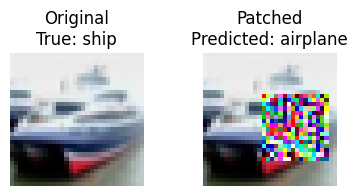

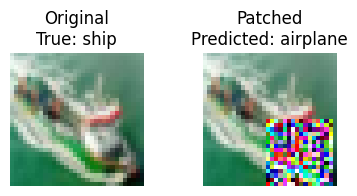

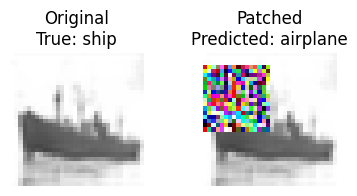

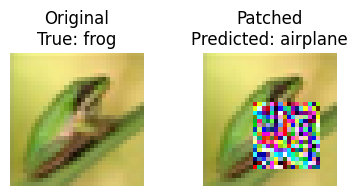

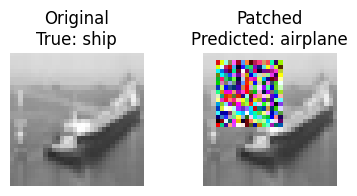

Targeted Attack Success Rate (Class 1): 8.66%


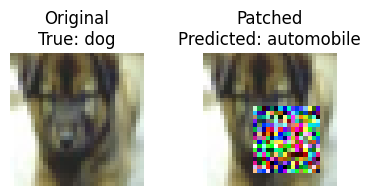

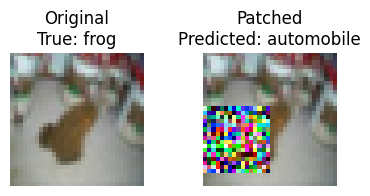

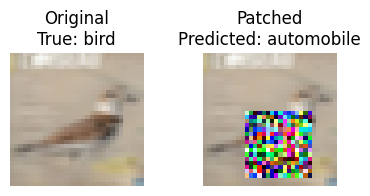

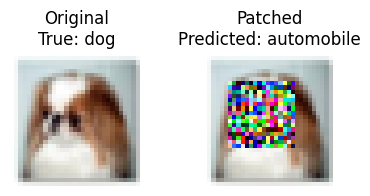

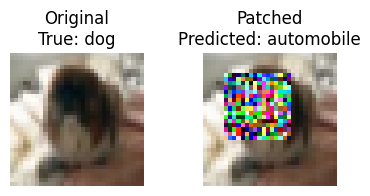

Targeted Attack Success Rate (Class 2): 9.98%


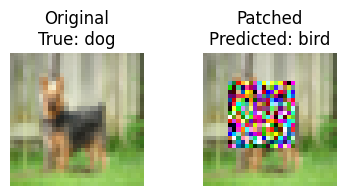

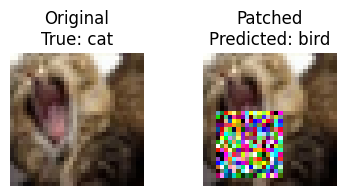

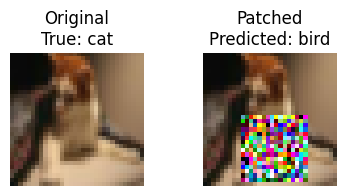

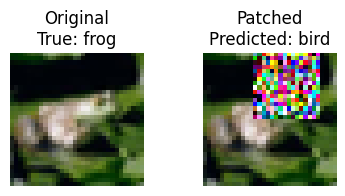

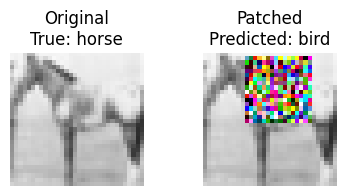

In [22]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 7 by 7

In [23]:
model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

<ipython-input-23-f07af1de2043>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)


<All keys matched successfully>

In [24]:
patch_size = (7, 7)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: airplane (0) ---
Epoch 1/20, Loss: 13.0910
Epoch 2/20, Loss: 13.0658
Epoch 3/20, Loss: 13.0339
Epoch 4/20, Loss: 12.9959
Epoch 5/20, Loss: 12.9588
Epoch 6/20, Loss: 12.9087
Epoch 7/20, Loss: 12.9020
Epoch 8/20, Loss: 12.8660
Epoch 9/20, Loss: 12.8332
Epoch 10/20, Loss: 12.8209
Epoch 11/20, Loss: 12.7873
Epoch 12/20, Loss: 12.7531
Epoch 13/20, Loss: 12.7360
Epoch 14/20, Loss: 12.7195
Epoch 15/20, Loss: 12.6835
Epoch 16/20, Loss: 12.6886
Epoch 17/20, Loss: 12.6485
Epoch 18/20, Loss: 12.6398
Epoch 19/20, Loss: 12.6256
Epoch 20/20, Loss: 12.5872
Saved patch to adversarial_patch_airplane_(7, 7).pth
--- Evaluating Patch for Target Class: airplane (0) ---
Targeted Attack Success Rate (Class 0): 10.97%

--- Training Patch for Target Class: automobile (1) ---
Epoch 1/20, Loss: 12.7797
Epoch 2/20, Loss: 12.7511
Epoch 3/20, Loss: 12.7044
Epoch 4/20, Loss: 12.6468
Epoch 5/20, Loss: 12.5997
Epoch 6/20, Loss: 12.5635
Epoch 7/20, Loss: 12.5358
Epoch 8/20, Loss: 1

<ipython-input-25-f5285ffa1fb1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 0): 11.73%


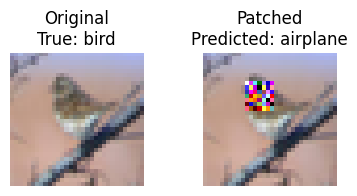

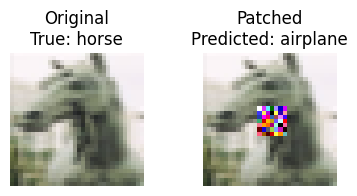

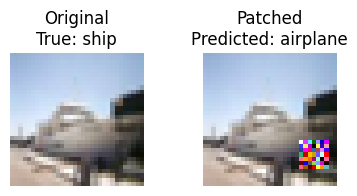

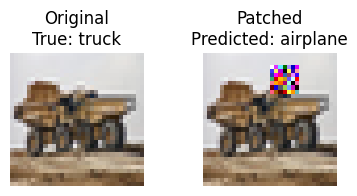

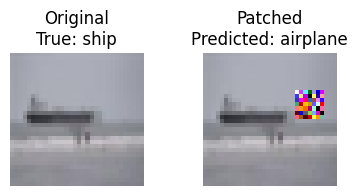

Targeted Attack Success Rate (Class 1): 9.70%


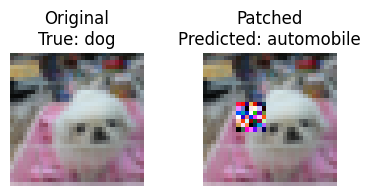

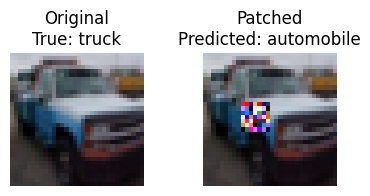

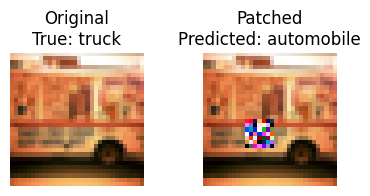

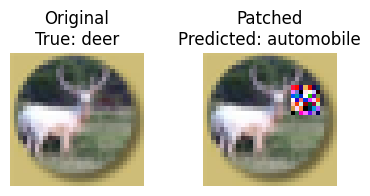

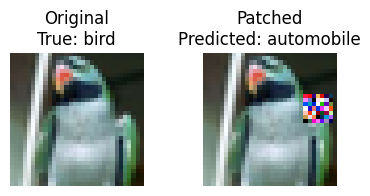

Targeted Attack Success Rate (Class 2): 10.52%


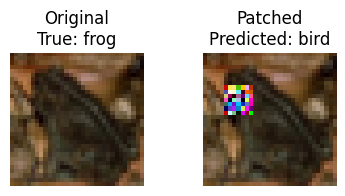

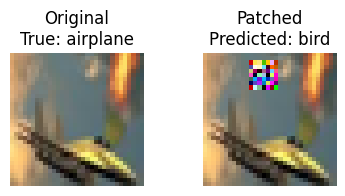

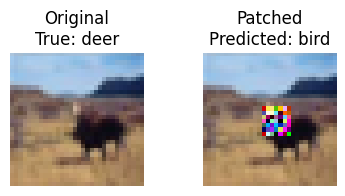

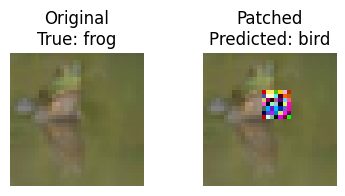

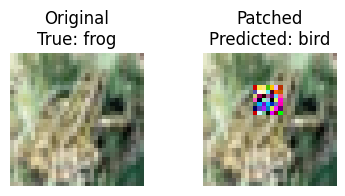

In [25]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

# 5 by 5

In [26]:
model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

<ipython-input-26-f07af1de2043>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)


<All keys matched successfully>

In [27]:
patch_size = (5, 5)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: airplane (0) ---
Epoch 1/20, Loss: 13.5544
Epoch 2/20, Loss: 13.5230
Epoch 3/20, Loss: 13.5000
Epoch 4/20, Loss: 13.4757
Epoch 5/20, Loss: 13.4423
Epoch 6/20, Loss: 13.4155
Epoch 7/20, Loss: 13.3894
Epoch 8/20, Loss: 13.3718
Epoch 9/20, Loss: 13.3422
Epoch 10/20, Loss: 13.3249
Epoch 11/20, Loss: 13.3099
Epoch 12/20, Loss: 13.3020
Epoch 13/20, Loss: 13.2758
Epoch 14/20, Loss: 13.2560
Epoch 15/20, Loss: 13.2327
Epoch 16/20, Loss: 13.2262
Epoch 17/20, Loss: 13.2127
Epoch 18/20, Loss: 13.2024
Epoch 19/20, Loss: 13.2003
Epoch 20/20, Loss: 13.1848
Saved patch to adversarial_patch_airplane_(5, 5).pth
--- Evaluating Patch for Target Class: airplane (0) ---
Targeted Attack Success Rate (Class 0): 10.38%

--- Training Patch for Target Class: automobile (1) ---
Epoch 1/20, Loss: 13.4962
Epoch 2/20, Loss: 13.4590
Epoch 3/20, Loss: 13.4162
Epoch 4/20, Loss: 13.3790
Epoch 5/20, Loss: 13.3385
Epoch 6/20, Loss: 13.3262
Epoch 7/20, Loss: 13.2854
Epoch 8/20, Loss: 1

<ipython-input-28-f5285ffa1fb1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 0): 10.34%


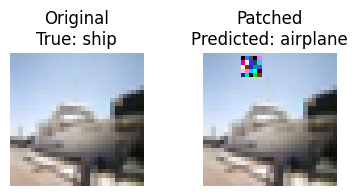

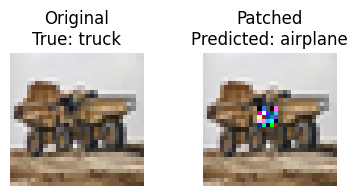

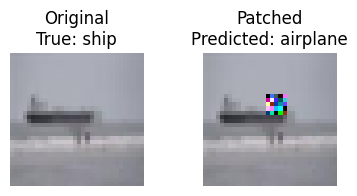

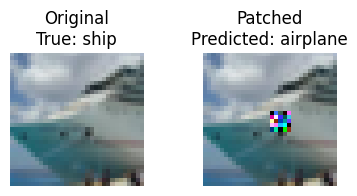

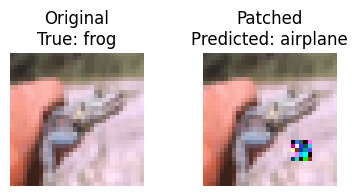

Targeted Attack Success Rate (Class 1): 9.79%


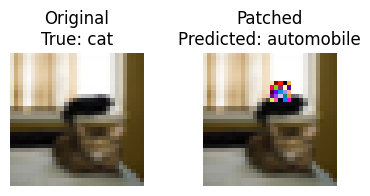

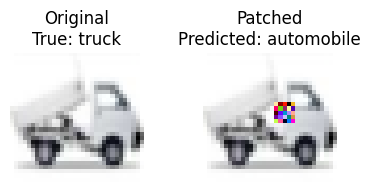

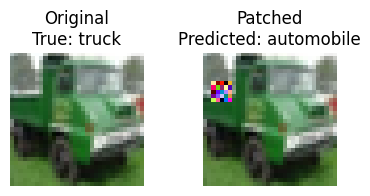

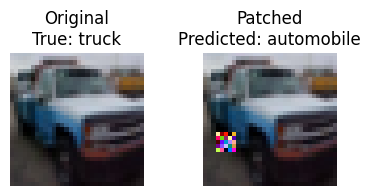

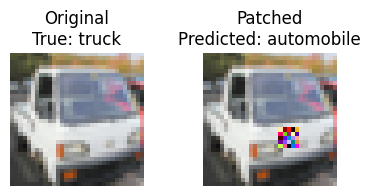

Targeted Attack Success Rate (Class 2): 10.48%


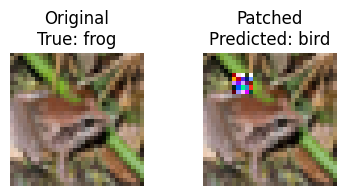

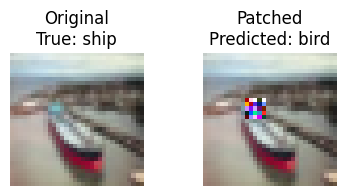

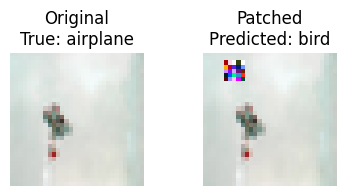

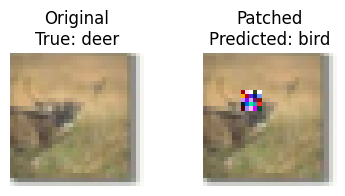

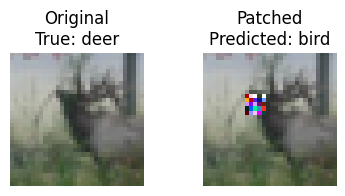

In [28]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )